In [6]:
import os
import scipy
import numpy as np
import pandas as pd
from collections import defaultdict
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib

import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)

from collections import defaultdict
from IPython.display import display, HTML

import seaborn as sns
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 50

%matplotlib inline 
current_palette = sns.color_palette()
cmap = current_palette.as_hex()

colors = {
    'deepens': '#1f77b4', 
    'dropout': '#ff7f0e',
    'kfacl': '#2ca02c',
    'onenet': '#d62728',
    'vi': '#9467bd',
    'csgld':'#8c564b',
    'sse':'#e377c2',
    'swag': '#7f7f7f', 
    'fge': '#bcbd22'}

names = {
    'acc': 'Accuracy (%)',
    'll': 'Log-Likelihood',
    'brier': 'Brier',
    'acc-aac': 'AURC'
}

names_ = {
    'deepens': 'Deep ensemble', 
    'dropout': 'Dropout',
    'kfacl': 'K-FAC-L',
    'onenet': 'Single model',
    'vi': 'FFG VI',
    'csgld':'cSGLD',
    'sse':'SSE',
    'swag': 'SWAG', 
    'fge': 'FGE'}

names_long = {
    'deepens': 'Deep ensemble', 
    'dropout': 'Dropout',
    'kfacl': 'KFAC-Laplace',
    'onenet': 'Single model',
    'vi': 'Variational Inf. (FFG)',
    'csgld':'Cyclic SGLD (cSGLD)',
    'sse':'Snapshot Ensembles (SSE)',
    'swag': 'SWA-Gaussian (SWAG)', 
    'fge': 'Fast Geometric Ens. (FGE)', 
    'stochbn':'SBN'}

    
precition = {
    'acc': '%.2f',
    'acc@5': '%.2f',
    'll':  '%.3f',
    'brier': '%.3f',
    'acc-aac': '%.4f'
}

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

current_palette = sns.color_palette()
cmap = ListedColormap(current_palette.as_hex())

# Reading log-files

In [7]:
!unzip logs.zip > unzip_out

In [8]:
path = './logs/'
df = pd.concat([pd.read_csv(path + f) for f in os.listdir(path)], sort=False)
df.model = df.model.apply(lambda x: x.replace('do', '').replace('Bayes', ''))
df.metric = df.metric.apply(lambda x: x.replace('_', '-'))
df.method = df.method.apply(lambda x: x.lower().replace('_', '-').replace('kfaclaplace', 'kfacl'))
df = df[df.metric.apply(lambda x: x in ['acc-aac', 'acc', 'll', 'brier'])]

df.model = df.model.apply(
    lambda x: x.replace('BN', '').replace('Pre', '').replace('28x10', ''))
dfbase_ung = df
dfbase = df.groupby(
    ['dataset', 'model', 'method', 'n_samples', 'metric']
).value.agg(['mean', 'std', len]).reset_index()
dfbase = dfbase[dfbase.method.apply(lambda x: 'stochbn' not in x)]

In [3]:
dfbase.sample(frac=0.0001).head(3)

,dataset,model,method,n_samples,metric,mean,std,len
64775,CIFAR100,ResNet110,swag (ts),94,ll,-0.701253,0.007837,5.0
113733,ImageNet,ResNet50,vi,98,acc-aac,0.068295,0.000030,5.0
25653,CIFAR10,VGG16,csgld,14,acc-aac,0.006084,0.000269,5.0


### How to read the table 

1. Methods (dfbase.method)
    - Available methods: ```kfacl, vi, csgld, sse, dropout, fge, swag, deepens, onenet```
    - All methods can be combined with ```'(ts)'``` substring that denotes a method with a temperature-scaling.
    - All methods can be combined with ```'-augment'``` substring that denotes a test-time augmentation---one augmentation of an image per one member of an ensemble.
2. Datasets (dfbase.dataset column): 
    - Available datasets: `CIFAR100, CIFAR10, ImageNet`
3. Models (dfbase.model):
    - Available models for CIFAR-10/100: ```VGG16, ResNet110, WideResNet, ResNet164```
    - Available model for ImageNet is ```ResNet50```
4. Size of an ensemble 
    - Number of members of an ensemble (`dfbase.n_samples`) typically is 1-100 for CIFARs and 1-50 for ImageNet.
5. Metrics:
    - Available metrics: `acc, ll, brier, acc-aac`
    - Where df.mean and df.std columns stores mean and standard deviation.
    
### How to work with data frame 
1. We find `df.query` quite usefull. There is an example: `dfbase.query("method=='deepens' and dataset=='ImageNet' and metric=='acc' and n_samples<5")`  
2. Iteration via a data frame is also very usefull. There is an example: `for row in dfbase.values[:3]: print (row)`

# Scatter plots

0.997


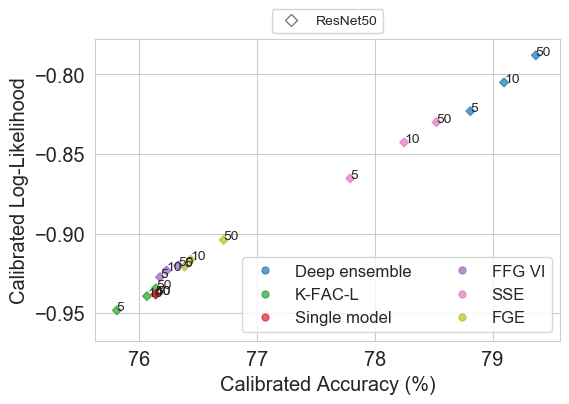

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'figure.figsize': (6, 4),
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
mpl.rcParams['figure.dpi'] = 100

data = 'ImageNet'
fig, ax = plt.subplots()
metric1, metric2 = 'acc', 'll'
methods = []

df = dfbase
ts = True
if ts: df = dfbase[dfbase.method.apply(lambda x: 'ts' in x)]
else:  df = dfbase[dfbase.method.apply(lambda x: 'ts' not in x)]


metric1_datas, metric2_datas = [], []

if data[:5] == "CIFAR":
    markers = {
    'ResNet110': "^", 
    'ResNet164': ">", 
    'VGG16': "s",
    'WideResNet': "*"}
else:
    markers = {'ResNet50': 'D'}

num = len(set(df.model.values))
for n_samples in ([5, 10, 50] if data == 'ImageNet' else [100]):
    for model in markers.keys():
        q = 'dataset == "%s" and model == "%s" and n_samples == %s ' % (data, model, n_samples)
        k1 = (1 if metric1 != 'acc' else 100)
        metric1_data = k1*(df.query(q + 'and metric == "%s"' % metric1)['mean'].values)
        metric1_std = k1*(df.query(q + 'and metric == "%s"' % metric1)['std'].values)
        
        k2 = (1 if metric2 != 'acc' else 100)
        metric2_data = k2 * df.query(q + 'and metric == "%s"' % metric2)['mean'].values
        metric2_std  = k2 * df.query(q + 'and metric == "%s"' % metric2)['std'].values

        txt = df.query(q + 'and metric == "%s"' % metric1)['method'].values
        
        idx = ["-augment" not in t for t in txt]
        metric1_data, metric2_data, txt, metric2_std, metric1_std = metric1_data[idx], metric2_data[idx], txt[idx], metric2_std[idx], metric1_std[idx]

        if len(metric1_data) > 0:
            metric1_datas += [metric1_data]
            metric2_datas += [metric2_data]
            methods += list(txt)
            
            c=[colors[t.replace(' (ts)', '')] for t in txt]
            
            if data == 'ImageNet':           
                for i in range(len(metric2_data)):
                    ax.annotate(str(n_samples), (metric1_data[i], metric2_data[i]))

            ax.scatter(metric1_data, metric2_data, marker=markers[model], s=20, alpha=0.7, c=c)
    
corr = np.corrcoef(np.hstack(metric1_datas), np.hstack(metric2_datas))
print('%.3f' % corr[0, 1])
plt.xlabel(('Calibrated ' if ts else '') + names[metric1])
plt.ylabel(('Calibrated ' if ts else '') + names[metric2])

methods = set(methods)

lines = [plt.Line2D([0,0], [0,0], color='black', fillstyle='none', marker=marker, linestyle='', markersize=6, alpha=0.5)
         for marker in markers.values()]
legend1 = plt.legend(lines, markers.keys(), ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.12 if data == 'ImageNet' else 1.2))

lines = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='', markersize=5, alpha=0.7) 
         for k, color in colors.items() if (k in methods or (k+' (ts)' in methods))]
linesc = [names_[k] for k, color in colors.items() if (k in methods or (k+' (ts)' in methods))]
plt.legend(lines, linesc, numpoints=1, ncol=2, loc='lower right', fontsize=12)
plt.gca().add_artist(legend1)

f = './pdf/%s-%s-vs-%s%s.pdf' % (data, metric1, metric2, '-ts' if ts else '')

plt.savefig(f, bbox_inches="tight", pad_inches=0.05)
plt.savefig('/Users/ars/Downloads/%s-%s-vs-%s%s.png' % (data, metric2, metric1, '-ts' if ts else ''), bbox_inches="tight", pad_inches=0.05)
plt.show()

# Plots

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'x-large',
         'figure.figsize': (6, 4),
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

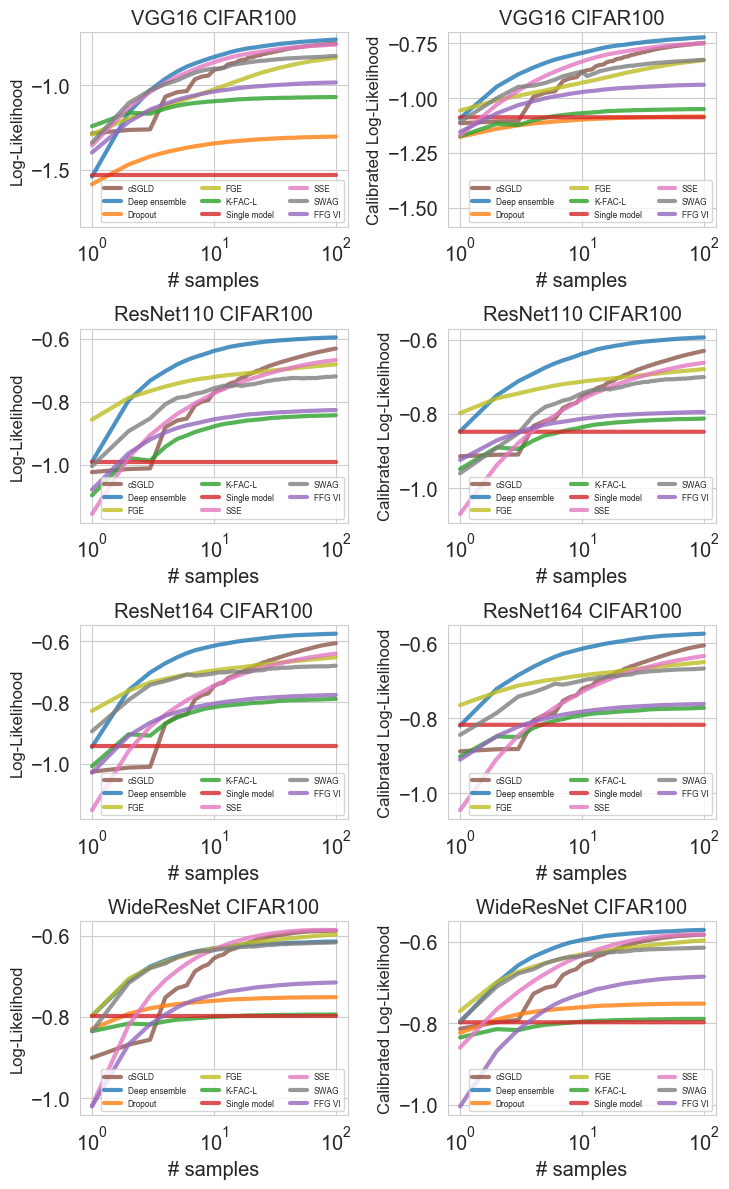

In [13]:
mpl.rcParams['figure.dpi'] = 100
metrics = ['ll', 'cll'] #, 'misclass-auroc', 'ece', 'brier']
compute = {
    'CIFAR10': ['VGG16', 'ResNet110', 'ResNet164', 'WideResNet'],
    'CIFAR100': ['VGG16', 'ResNet110', 'ResNet164', 'WideResNet'],
    'ImageNet': ['ResNet50']
}
mpl.rcParams['figure.figsize'] = 3.7*len(metrics), 3*len(compute[data])


data = 'CIFAR100'
sns.set_style('whitegrid')
plot_std = False

i = 1
methods = []
cmap = current_palette.as_hex()

min_ = +10**1000

for model in compute[data]:
    for metric in metrics:
        plt.subplot(len(compute[data]), len(metrics), i)
        i += 1
        
        if metric == 'll':
            ts = False
            df = dfbase
            if ts: df = dfbase[dfbase.method.apply(lambda x: 'ts' in x)]
            else:  df = dfbase[dfbase.method.apply(lambda x: 'ts' not in x)]
            metric_='ll'
        else:
            ts = True
            df = dfbase
            if ts: df = dfbase[dfbase.method.apply(lambda x: 'ts' in x)]
            else:  df = dfbase[dfbase.method.apply(lambda x: 'ts' not in x)]
            metric='ll'
            metric_='cll'

        for method in sorted(set(df.method.values)):
            if 'augment' in method:
                continue
            q    = 'dataset == "%s" and model == "%s" and method == "%s" and metric == "%s"'
            df_  = df.query(q % (data, model, method, metric))
            q_   = 'dataset == "%s" and model == "%s" and method == "%s"' 
            df__ = df.query(q_ % (data, model, method))
            if len(df__ ) > 0:
                method_ = method.replace(' (ts)', '').split('-')[0]
                m = method.replace(' (ts)', '')
                c = colors[method_]
                
                min_ = np.min([min_, np.min(df_['mean'].values)]) 
                
                plt.plot(df_['n_samples'].values, df_['mean'].values, 
                        label=names_[m], alpha=0.8, c=c, linestyle='-' if '-augment' not in method else '--', lw=3)

        plt.xscale('log')
        if model == 'VGG16' :
            plt.ylim(min_-(0.25 if metric_=='ll' else 0), None)
        plt.ylabel(('Calibrated ' if ts else '') + names[metric], fontsize=12)
        plt.xlabel('# samples')
        plt.title('%s %s' % (model, data))
        plt.legend(ncol=3, loc='lower right', fontsize=6)


plt.tight_layout()
plt.savefig('./pdf/%s-side-by-side-befor-and-after-calibraion-ll.pdf' % data, bbox_inches='tight')

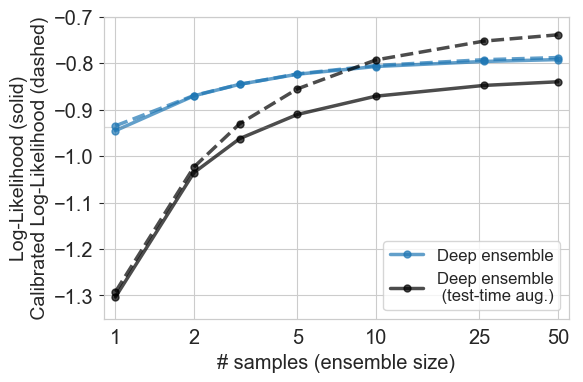

In [8]:
data = 'ImageNet'
metrics = ['ll'] 

compute = {
    'CIFAR10': ['VGG16', 'ResNet110', 'ResNet164', 'WideResNet'],
    'CIFAR100': ['VGG16', 'ResNet110', 'ResNet164', 'WideResNet'],
    'ImageNet': ['ResNet50']
}

mpl.rcParams['figure.figsize'] = 6*len(metrics), 4*len(compute[data])
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
mpl.rcParams['figure.dpi'] = 100
df = dfbase
current_palette = sns.color_palette()
cmap = ListedColormap(current_palette.as_hex())

sns.set_style('whitegrid')
plot_std = False

i = 1
methods = []
cmap = current_palette.as_hex()
fig, ax1 = plt.subplots()
idx = [0, 1, 2, 4, 9, 25, -1]
for model in compute[data]:
    for metric in metrics:
        i += 1
        for i, method in enumerate(sorted(set(df.method.values))):
            if 'deepens' not in method :
                continue
            q    = 'dataset == "%s" and model == "%s" and method == "%s" and metric == "%s"'
            df_  = df.query(q % (data, model, method, metric))
            q_   = 'dataset == "%s" and model == "%s" and method == "%s"' 
            df__ = df.query(q_ % (data, model, method))
            if len(df__ ) > 0:
                method_ = method.replace(' (ts)', '').split('-')[0]
                if method_ in colors:
                    c = colors[method_]
                else:
                    colors[method_] = cmap[len(colors) % 10]
                    c = colors[method_]
                    
                m = method.replace(' ( )','').replace('-augment', '')
                
                if 'ts' not in method:
                    ax1.plot(df_['n_samples'].values[:50][idx], df_['mean'].values[:50][idx], 'o-' if 'ts' not in method else 'o--',
                            label=(names_[m] if 'augment' not in method else (names_[m] +'\n (test-time aug.)')) if 'ts' not in method else None, 
                             alpha=0.7, 
                             c=colors[method.replace(' (ts)','').replace('-augment', '')] if 'augment' not in method else 'black', lw=2.5, ms=5)
            if i == 6: 
                ax1.plot([0, 60], [-0.938, -0.938], '-', ms=5, lw=0.9, color='gray', alpha=0.3)
            plt.legend(ncol=1, loc='lower right', fontsize=12)
    
ax2 = ax1.twinx()             
for model in compute[data]:
    for metric in metrics:
        i += 1
        for method in sorted(set(df.method.values)):
            if 'deepens' not in method :
                continue
            q    = 'dataset == "%s" and model == "%s" and method == "%s" and metric == "%s"'
            df_  = df.query(q % (data, model, method, metric))
            q_   = 'dataset == "%s" and model == "%s" and method == "%s"' 
            df__ = df.query(q_ % (data, model, method))
            if len(df__ ) > 0:
                method_ = method.replace(' (ts)', '').split('-')[0]
                if method_ in colors:
                    c = colors[method_]
                else:
                    colors[method_] = cmap[len(colors) % 10]
                    c = colors[method_]

                m = method.replace(' (ts)','').replace('-augment', '')

                if 'ts' in method:
                    ax2.plot(df_['n_samples'].values[:50][idx], df_['mean'].values[:50][idx], 'o-' if 'ts' not in method else 'o--',
                            label=(names_[m] if 'augment' not in method else (names_[m] +' (test-time aug.)')) if 'ts' not in method else None, 
                             alpha=0.7, 
                             c=colors[method.replace(' (ts)','').replace('-augment', '')] if 'augment' not in method else 'black', lw=2.5, ms=5)

    plt.xscale('log', basex=5)
    plt.xticks([1, 2, 5, 10, 25, 50], ('1', '2', '5', '10', '25', '50'))
    ax1.set_ylabel(names[metric]+' (solid)\n Calibrated %s (dashed) ' % names[metric], fontsize=14)
    ax1.set_xlabel('# samples (ensemble size)')
    plt.yticks([])
    ax1.set_ylim(-1.35, -0.7)
    ax2.set_ylim(-1.35, -0.7)
    ax2.set_xlim(0.9, 55)
    ax1.set_xlim(0.9, 55)

plt.savefig('./pdf/%s-%s-%s.pdf' % (data, str(compute[data]), str(metrics), ), bbox_inches='tight', pad_inches=0.05)

# DEE

In [9]:
!unzip df_dee_no_augment.csv.zip > unzip_out

In [9]:
df = pd.read_csv('./df_dee_no_augment.csv')
df.model = df.model.apply(lambda x: x.replace('do', '').replace('Bayes', ''))
df.metric = df.metric.apply(lambda x: x.replace('_', '-'))
df.method = df.method.apply(lambda x: x.lower().replace('_', '-').replace('kfaclaplace', 'kfacl'))

df.model = df.model.apply(
    lambda x: x.replace('BN', '').replace('Pre', '').replace('28x10', ''))
df = df[df.method.apply(lambda x: 'ts' in x)]
df = df[df.method.apply(lambda x: 'aug' not in x)]
df = df[df.method != 'stochbn']
df = df[df.metric == 'll']
df.value = df.dee
df.metric = len(df.dee)*['dee']

df.method = df.method.apply(lambda x: x.replace('-augment', '').replace(' (ts)', ''))

/Users/ars/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


In [10]:
def get_cost_per_dee(method, dataset, model):
    if dataset in ['CIFAR10', 'CIFAR100']:
        if method == 'sse':
            return 45, 0
        elif method in ['fge', 'swag']:
            return 2, 160
        elif method == 'csgld':
            return 50/3, 0
        elif method=='deepens':
            if model == 'VGG16':
                return 400, 0
            else:
                return 300, 0
        elif method=='dropout':
            return 0, 400
        elif method in ['kfacl', 'onenet', 'vi']:
            if model == 'VGG16':
                return 0, (400 + (100 if method == 'vi' else 0))
            else:
                return 0, (300 + (100 if method == 'vi' else 0))
    else:
        if method == 'fge':
            return 2, 130
        elif method == 'kfacl':
            return 0, 130
        elif method == 'onenet':
            return 0, 130
        elif method == 'sse':
            return 45, 0
        elif method == 'vi':
            return 0, 130+45
        elif method == 'deepens':
            return 130, 0


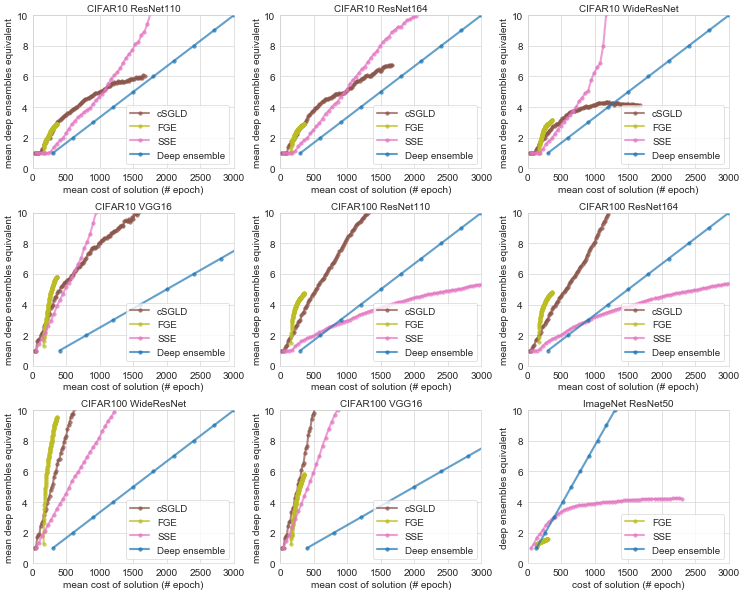

In [11]:
mpl.rcParams['figure.dpi'] = 50
mpl.rcParams['figure.figsize'] = 5*3, 4*3
from collections import defaultdict
ds, ss, sizes = defaultdict(lambda: defaultdict(lambda: [])), defaultdict(lambda : defaultdict(lambda: [])), defaultdict(lambda : defaultdict(lambda: []))

for k, data in enumerate(['CIFAR10', 'CIFAR100', 'ImageNet']):
    
    if data == 'ImageNet':
        models = ['ResNet50']
    else:
        models = ['ResNet110', 'ResNet164', 'WideResNet', 'VGG16']
    for i, model in enumerate(models):
        plt.subplot(3, 3, 4*k + i+1)
        for method in list(set(df.query('dataset == "%s"' % data).method.values)):
            if method not in {'csgld', 'deepens', 'fge', 'sse'}: 
                continue
            q = 'dataset == "%s" and method == "%s"  and model=="%s"' % (data, method, model)
            if len(df.query(q)):
                samples = df.query(q).n_samples.values
                deescore = df.query(q).dee.values
                cps, prc = get_cost_per_dee(method, data, model)
                cost = np.cumsum([cps+prc] + [cps]*(len(samples)-1))
#                 if method == 'csgld':
#                     cost = np.cumsum([48, 1, 1] *int(len(samples)/3+1))[:len(samples)]

                plt.plot(cost, deescore, '-o', label=names_[method], lw=3, alpha=0.7, ms=5, c=colors[method])#, s=samples**1.1, )
                plt.ylim(0, 10)
                plt.xlim(0, 3000)
                
                ds[data][method] += [deescore]
                ss[data][method] += [cost]
                sizes[data][method] += [samples]
            
        plt.legend(ncol=1, loc='lower right', fontsize=14)
        plt.title('%s %s' % (data, model))
        plt.xlabel(('mean ' if data!='ImageNet' else '' ) + 'cost of solution (# epoch)')
        plt.ylabel(('mean ' if data!='ImageNet' else '' ) + 'deep ensembles equivalent')
plt.tight_layout()
plt.savefig('./pdf/cost-vs-dee.pdf')

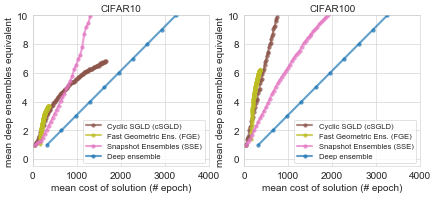

In [12]:
mpl.rcParams['figure.dpi'] = 50
mpl.rcParams['figure.figsize'] = 5*2, 4

for k, data in enumerate(['CIFAR10', 'CIFAR100']):  
    plt.subplot(1, 2, k+1)
    for method in list(set(df.query('dataset == "%s"' % data).method.values)):
        if method not in {'csgld', 'deepens', 'fge', 'sse'}: 
            continue
        plt.plot(np.mean(ss[data][method], axis=0), np.mean(ds[data][method], axis=0), '-o', label=names_long[method], lw=3, alpha=0.7, ms=5, c=colors[method])
        plt.xlabel(('mean ' if data!='ImageNet' else '' ) + 'cost of solution (# epoch)')
        plt.ylabel(('mean ' if data!='ImageNet' else '' ) + 'deep ensembles equivalent')
    plt.title('%s' % (data))
    plt.ylim(-0.5, 10)
    plt.xlim(0, 4000)
    plt.legend(ncol=1, loc='lower right', fontsize=11)
plt.savefig('./pdf/cost-vs-dee-mean.pdf',bbox_inches='tight', pad_inches=0.05)